In [1]:
import pandas as pd
import numpy as np

import csv, pickle, glob, bz2

from datetime import datetime

#import dill as pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Computer Modern']})
# rc('text', usetex = True)

# Local path to dropbox Paths
path_to_vatic_outputs = r'/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/'
path_to_images        = r'/Users/Guille/Dropbox/ProcessedDataTexas/images/'
path_to_solar_fc      = '/Users/Guille/Dropbox/HighLevel-Data/solar_day_ahead_forecast_2018.csv'
path_to_wind_fc       = '/Users/Guille/Dropbox/HighLevel-Data/wind_day_ahead_forecast_2018.csv'

# Vatic report features
vatic_ = ['Fixed Costs',       'Variable Costs',  'Load Shedding',        'Over Generation',        'Available Reserves',     
          'Reserve Shortfall', 'Renewables Used', 'Renewables Available', 'Renewables Curtailment', 'Demand',             
          'Price',             'Number on/offs',  'Sum on/off ramps',     'Sum nominal ramps']

# Load shyncronized Vatic and scenarios data

* The structure in the scenarios is [days x zones x hours x scenarios]
* The structure in the Vatic reports is [days x feature x hours x scenarios]

In [2]:
# Load cnlsim scenarios organized by zones
def _loadScen(file_name):

    with open(file_name, 'rb') as f:
        scen_ = pickle.load(f)

    load_, solar_, wind_                    = scen_
    load_data_, load_zones_, _              = load_
    solar_data_, solar_zones_, solar_names_ = solar_
    wind_data_, wind_zones_, wind_names_    = wind_
    load_zones_                             = np.array(load_zones_)
    #print(solar_names_)
    #print(load_data_.shape, load_zones_.shape)
    #print(solar_data_.shape, solar_zones_.shape, solar_names_.shape)
    #print(wind_data_.shape, wind_zones_.shape, wind_names_.shape)

    solar_ = []
    wind_  = []
    for zone in load_zones_:
        #print(zone)
        idx_ = solar_zones_ == zone

        if idx_.sum() == 0:
            solar_.append(np.zeros((1, 1000, 24)))
        else:
            solar_.append(np.sum(solar_data_[idx_, ...], axis = 0)[np.newaxis, ...])

        idx_ = wind_zones_ == zone
        if idx_.sum() == 0:
            wind_.append(np.zeros((1, 1000, 24)))
        else:
            wind_.append(np.sum(wind_data_[idx_, ...], axis = 0)[np.newaxis, ...])

    L_ = load_data_
    S_ = np.swapaxes(np.concatenate(solar_, axis = 0), 1, 2)
    W_ = np.swapaxes(np.concatenate(wind_, axis = 0), 1, 2)

    return L_, S_, W_, load_zones_

# Load Vatic Reports for a give file
def _loadVatic(path):
    summary_ = []
    idx_ = []
    for file_ in glob.glob(path + r'/*'):
        idx1 = file_.find('2_s')
        idx2 = file_.find('_clnSim')
        idx_.append(int(file_[idx1 + 3:idx2]))
        summary_.append(pd.read_pickle(file_).to_numpy()[..., np.newaxis])
    return np.swapaxes(np.concatenate(summary_, axis = 2)[..., np.argsort(np.array(idx_))], 0, 1)

# Load zonal scenarios and Vatic reports 
allL_  = []
allS_  = []
allW_  = []
allV_  = []
dates_ = []
for file_ in glob.glob(path_to_vatic_outputs + 'ProcessedScenTexas/*'):
    print(file_)
    dates_.append(file_[-14:-4])
    L_, S_, W_, load_zones_ = _loadScen(file_)
    V_ = _loadVatic(path_to_vatic_outputs + 'VaticReportTexas/' + file_[-14:-4])
    allL_.append(L_)
    allS_.append(S_)
    allW_.append(W_)
    allV_.append(V_)

# Organize dataset in chronological order
dates_ = np.array(dates_)
dates_ = dates_[np.argsort(dates_)]
# Load scenarios
allL_  = np.stack(allL_)[np.argsort(dates_), ...]
# Solar scenarios
allS_  = np.stack(allS_)[np.argsort(dates_), ...]
# Wind scenarios
allW_  = np.stack(allW_)[np.argsort(dates_), ...]
# Vatic report per scenarios
allV_  = np.stack(allV_)[np.argsort(dates_), ...]
print(allL_.shape, allS_.shape, allW_.shape, allV_.shape)

/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-05-10.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-09-04.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-02-26.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-12-27.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-09-14.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-11-13.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-01-02.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-08-18.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-04-24.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-06-30.pkl
/Users/Guille/Dropbox/Processe

## Aggreated Scenarios 

* Find extreme scenarios: load shedding or/and renewable energy curtailment

2018-06-30
195 336 175
(array([15]), array([994]))
(array([8]), array([382]))


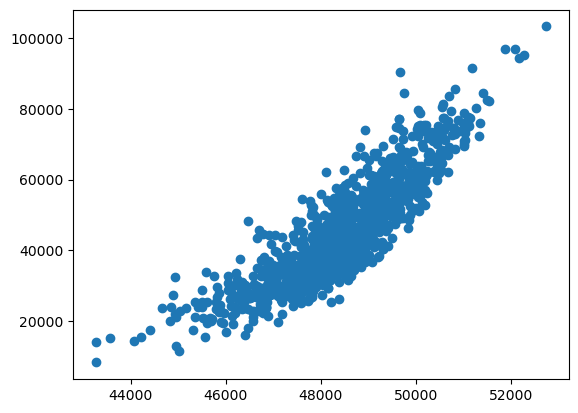

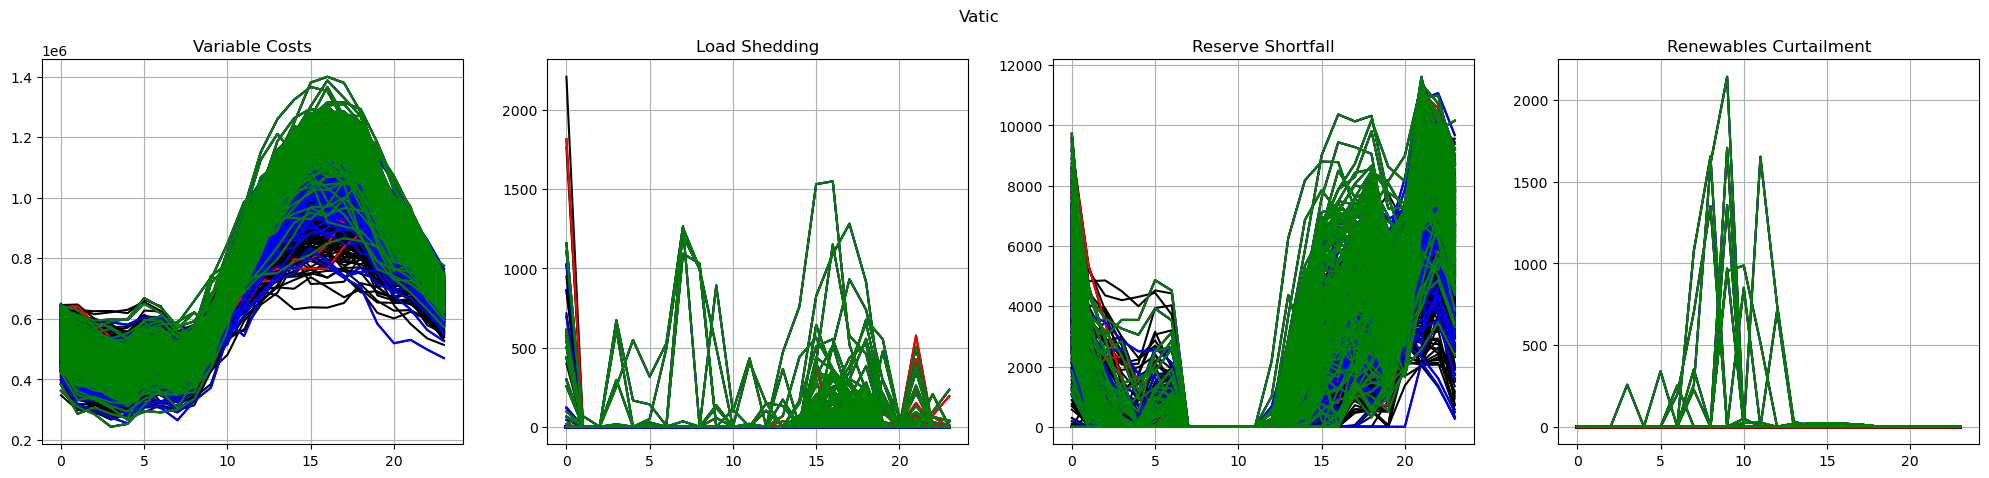

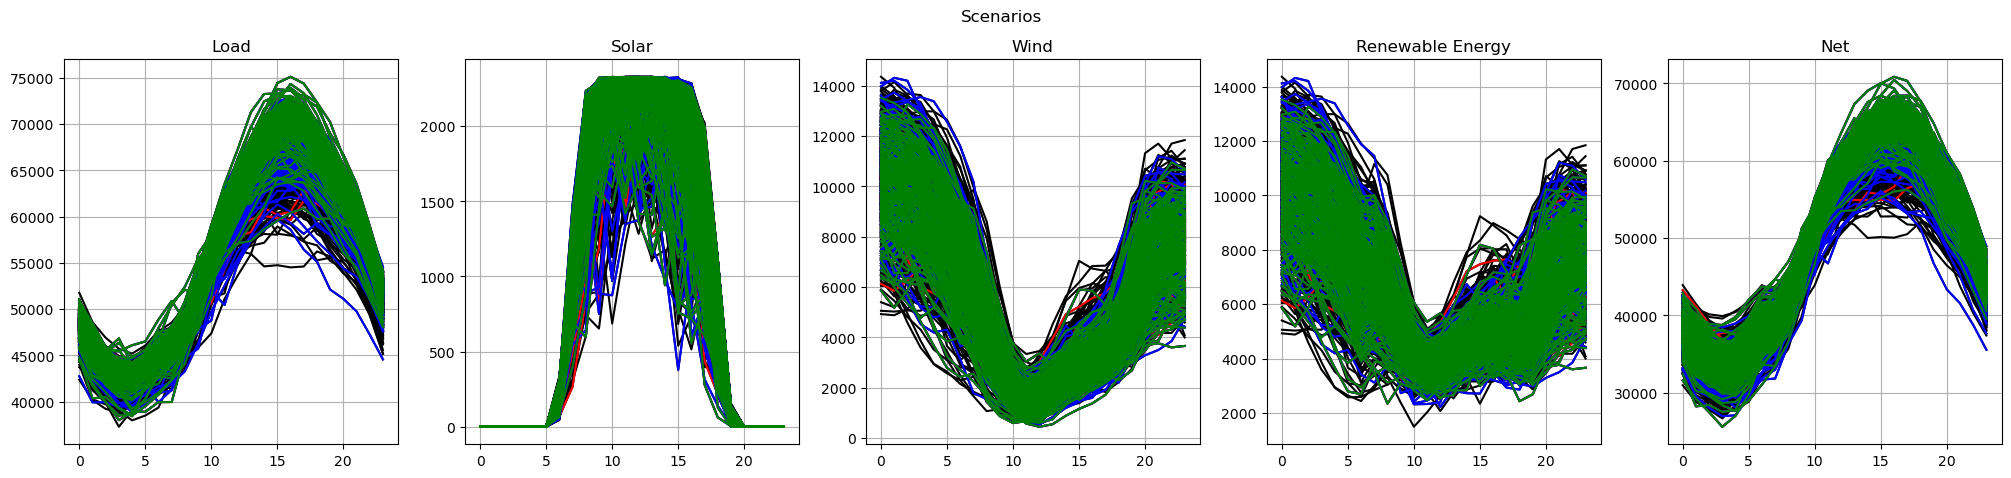

In [3]:
# Index day to plot
i_day = 12
print(dates_[i_day])

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())


print(np.where(allV_[i_day, 2, 1:-1, :] == allV_[i_day, 2, 1:-1, :].max()))
print(np.where(allV_[i_day, 8, 1:-1, :] == allV_[i_day, 8, 1:-1, :].max()))


L_ = np.sum(allL_[i_day, ...], axis = 0) - np.sum(allS_[i_day, ...], axis = 0) - np.sum(allW_[i_day, ...], axis = 0)
        
plt.figure()
plt.scatter(np.mean(L_, axis = 0), np.sum(allV_[i_day, 5, ...], axis = 0))
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Vatic')
plt.subplot(141)
i_vatic = 1
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(142)
i_vatic = 2
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(143)
i_vatic = 5
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(144)
i_vatic = 8
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Scenarios')
plt.subplot(151)
plt.title('Load')
plt.plot(np.sum(allL_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.plot(np.sum(allS_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.plot(np.sum(allW_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(154)
plt.title('Renewable Energy')
plt.plot(np.sum(allS_[i_day, ...], axis = 0) 
         + np.sum(allW_[i_day, ...], axis = 0), 'k')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]]
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(155)
plt.title('Net')
plt.plot(np.sum(allL_[i_day, ...], axis = 0) 
          - np.sum(allS_[i_day, ...], axis = 0) 
              - np.sum(allW_[i_day, ...], axis = 0), 'k')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]]
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()
plt.show()

## Zonal Scenarios 

* Find extreme scenarios: load shedding or/and renewable energy curtailment

2018-01-02
36 368 26


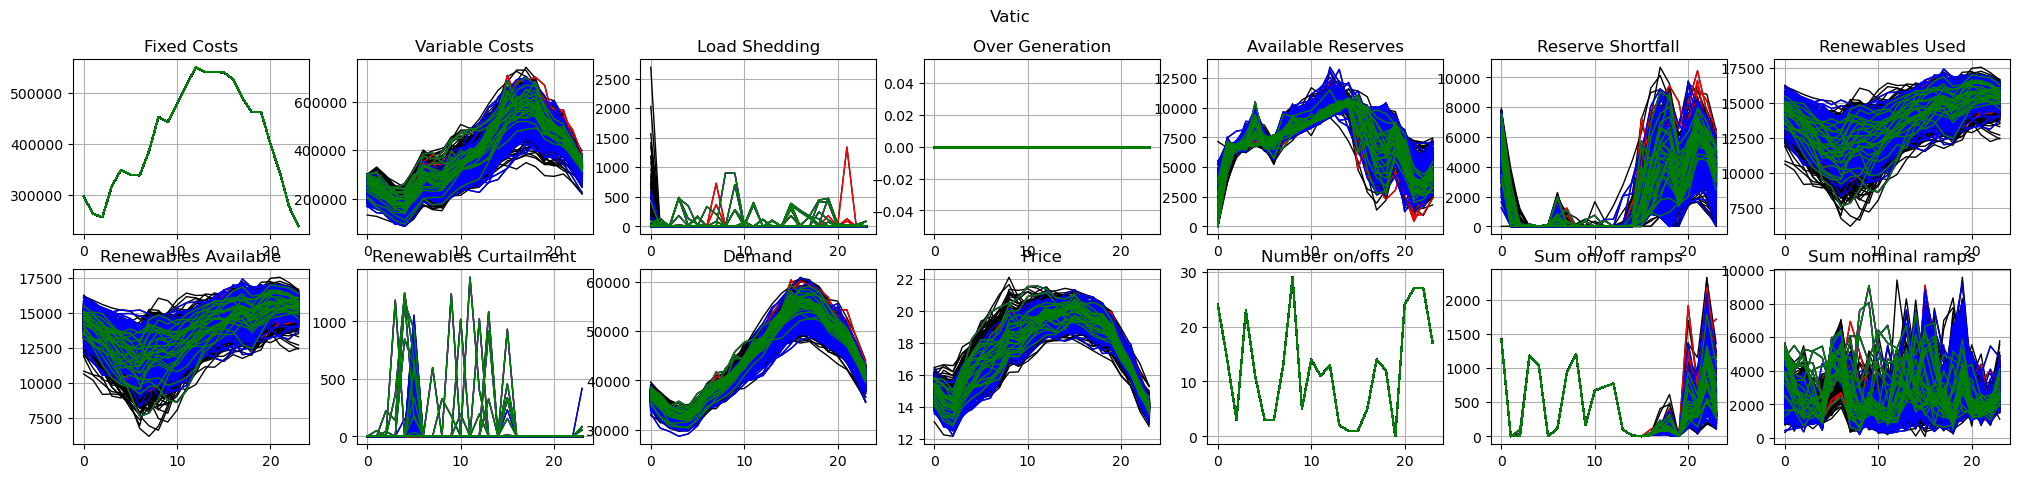

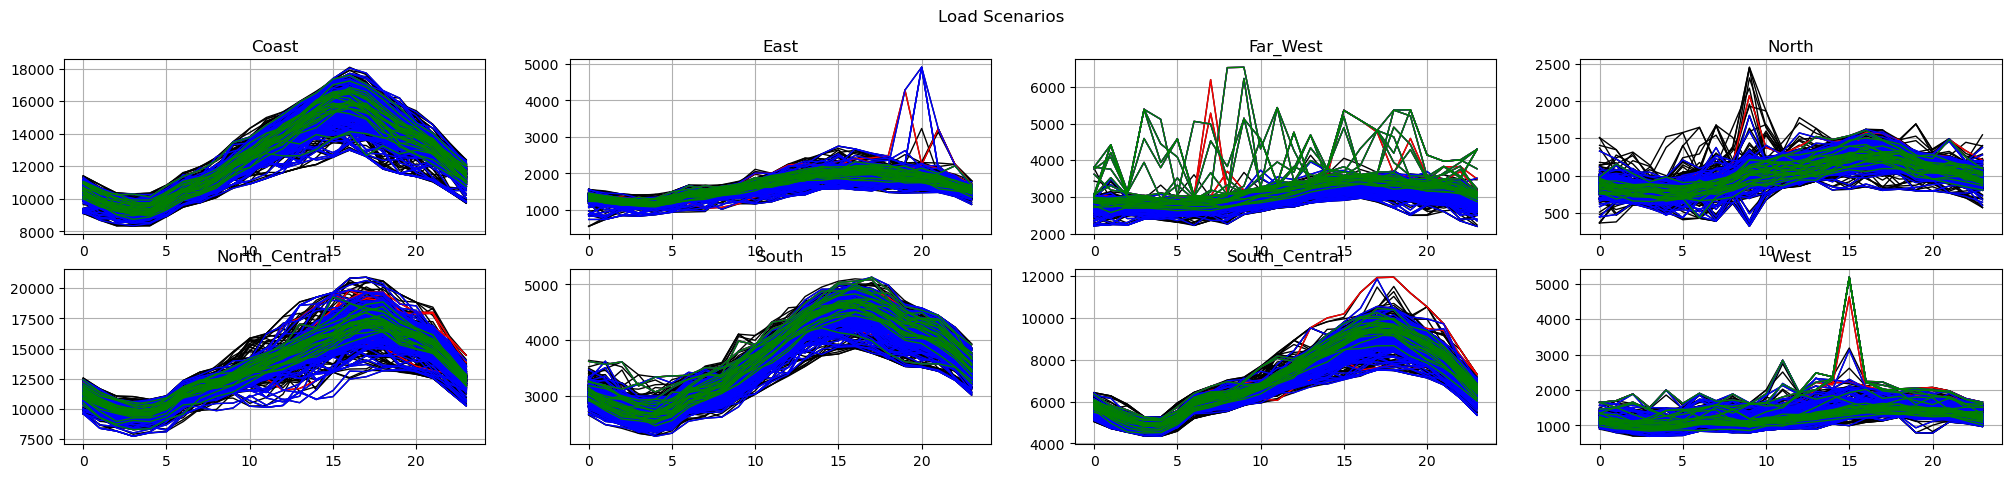

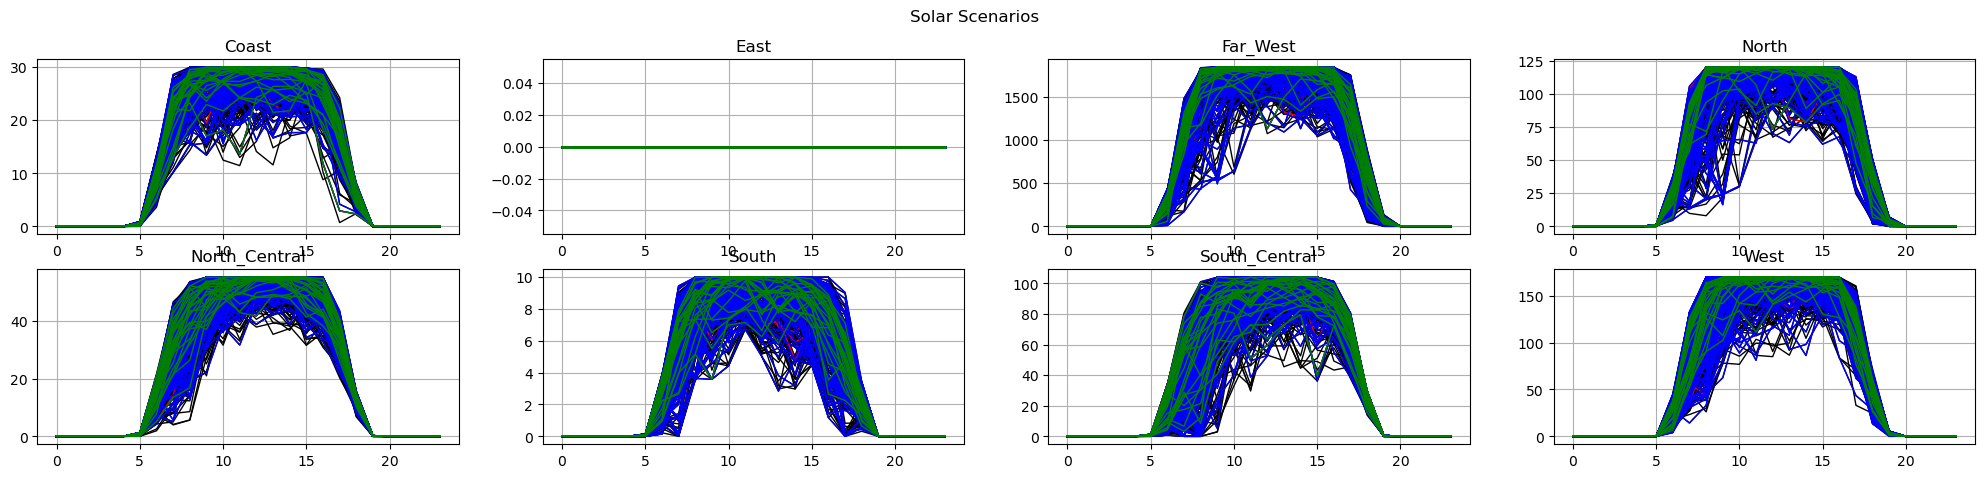

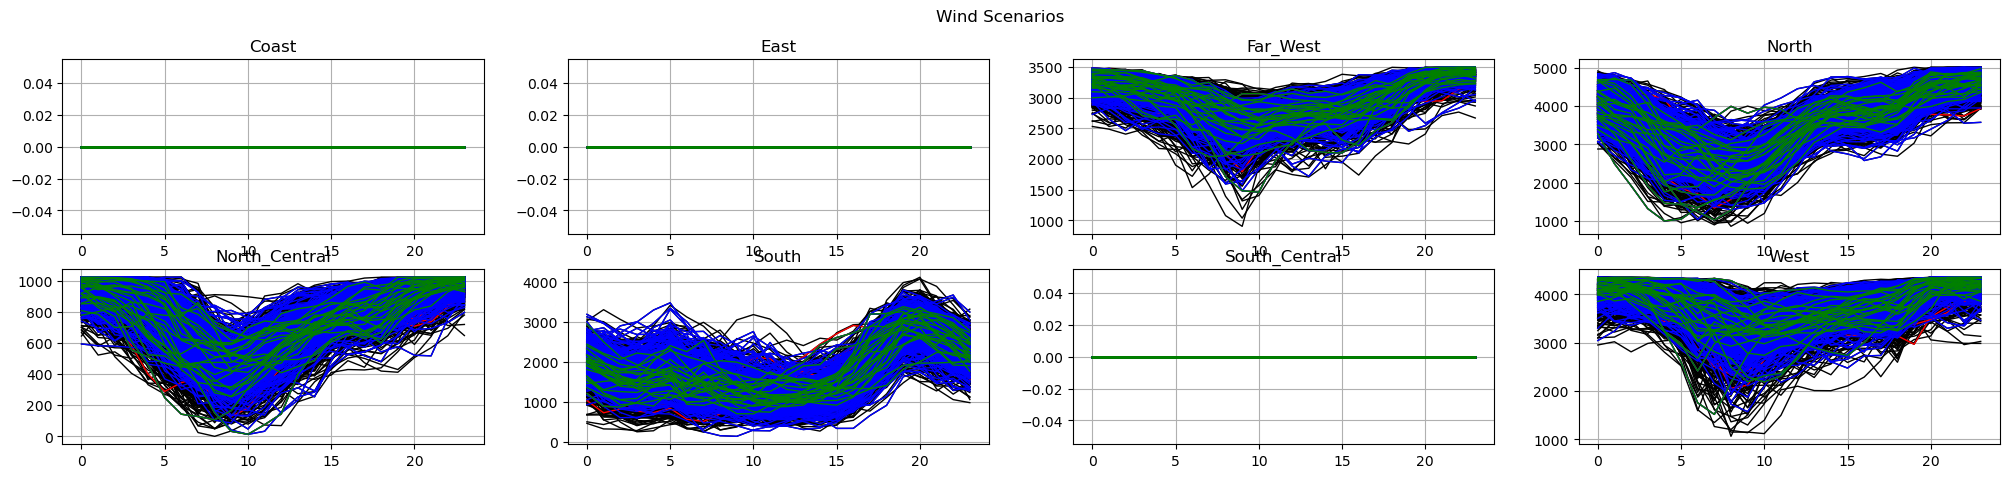

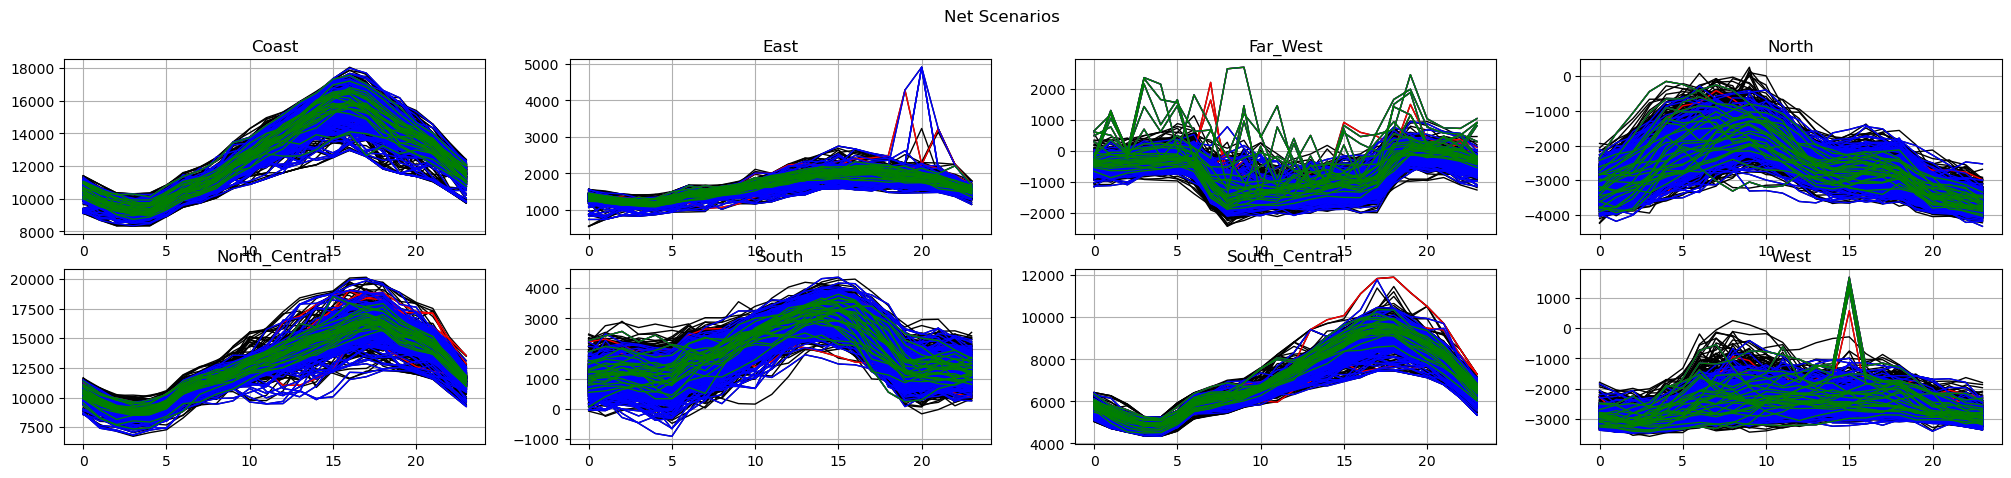

In [4]:
# Index day to plot
i_day = 0
print(dates_[i_day])

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

plt.figure(figsize = (25, 5))
plt.suptitle('Vatic')
for j in range(14):
    plt.subplot(2, 7, j + 1)
    plt.title(vatic_[j])
    plt.plot(allV_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Load Scenarios')

for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allL_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Solar Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allS_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Wind Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allW_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Net Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allL_[i_day, j, ...] - allS_[i_day, j, ...] - allW_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_]].T - allS_[i_day, j, :, idxScen_[idxShed_]].T - allW_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxCurt_]].T - allS_[i_day, j, :, idxScen_[idxCurt_]].T - allW_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T - allS_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T - allW_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

In [5]:
from matplotlib.pyplot import rc
import matplotlib.pyplot as plt

import os, glob, csv

import pandas as pd
import numpy as np

# #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex = True)

zones_    = ['Agg.', 'Coast', 'East', 'Far West', 'North', 'North Central', 'South', 'South Central', 'West']
features_ = ['Load', 'Solar Generation', 'Wind Generation', 'VRE Generation', 'Net Load']
vatic_    = ['Operational Costs', 'Load Shedding', 'VRE Curtailment', 'Reserve Shortfall']

In [6]:
# Index day to plot
i_day     = 19
print(dates_[i_day])

L_ = np.concatenate([np.sum(allL_[i_day, ...], axis = 0)[np.newaxis, ...], allL_[i_day, ...]], axis = 0)
S_ = np.concatenate([np.sum(allS_[i_day, ...], axis = 0)[np.newaxis, ...], allS_[i_day, ...]], axis = 0)
W_ = np.concatenate([np.sum(allW_[i_day, ...], axis = 0)[np.newaxis, ...], allW_[i_day, ...]], axis = 0)
G_ = S_ + W_
N_ = L_ - G_
X_ = [L_, S_, W_, G_, N_]
print(L_.shape, S_.shape, W_.shape, G_.shape, N_.shape)

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
Shed_    = np.sum(allV_[i_day, 2, :, :], axis = 0)
idxShed_ = Shed_ > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
Curt_    = np.sum(allV_[i_day, 8, :, :], axis = 0)
idxCurt_ = Curt_ > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

Cost_    = np.sum(allV_[i_day, 1, :, :], axis = 0)
Short_   = np.sum(allV_[i_day, 5, :, :], axis = 0)

print(np.where(allV_[i_day, 2, 1:-1, :] == allV_[i_day, 2, 1:-1, :].max()))
print(np.where(allV_[i_day, 8, 1:-1, :] == allV_[i_day, 8, 1:-1, :].max()))

sortShed_  = np.argsort(Shed_)[::-1]
sortCurt_  = np.argsort(Curt_)[::-1]
sortCost_  = np.argsort(Cost_)[::-1]
sortShort_ = np.argsort(Short_)[::-1]
idxCost_   = idxScen_ < 50
idxShort_  = idxScen_ < 50

sort_  = [sortCost_, sortShed_, sortCurt_, sortShort_]
total_ = [Cost_, Shed_, Curt_, Short_]
idx_   = [idxCost_, idxShed_, idxCurt_, idxShort_]
print(sortCost_.shape, idxCost_.shape, Cost_.shape, sortShed_.shape, idxShed_.shape, Shed_.shape)

2018-10-04
(9, 24, 1000) (9, 24, 1000) (9, 24, 1000) (9, 24, 1000) (9, 24, 1000)
55 115 27
(array([0]), array([595]))
(array([14]), array([760]))
(1000,) (1000,) (1000,) (1000,) (1000,) (1000,)


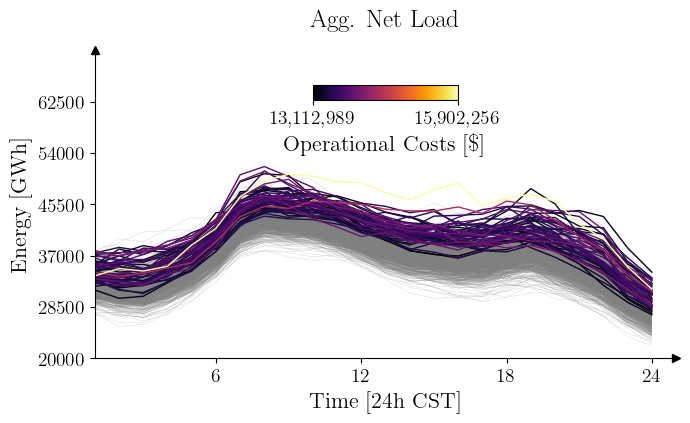

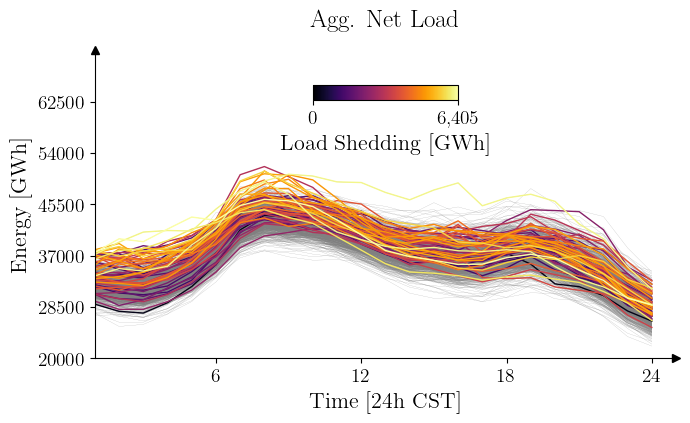

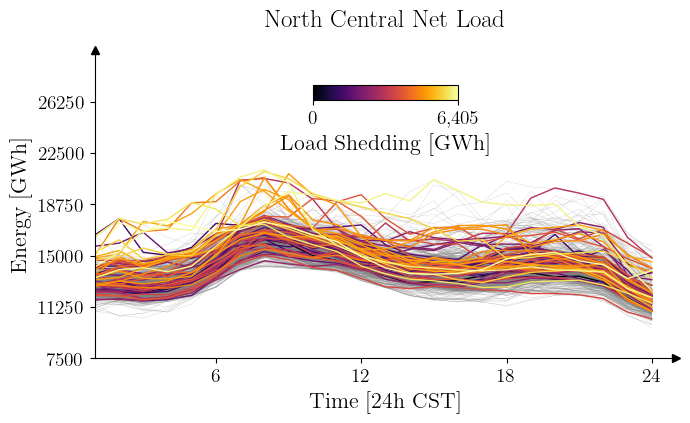

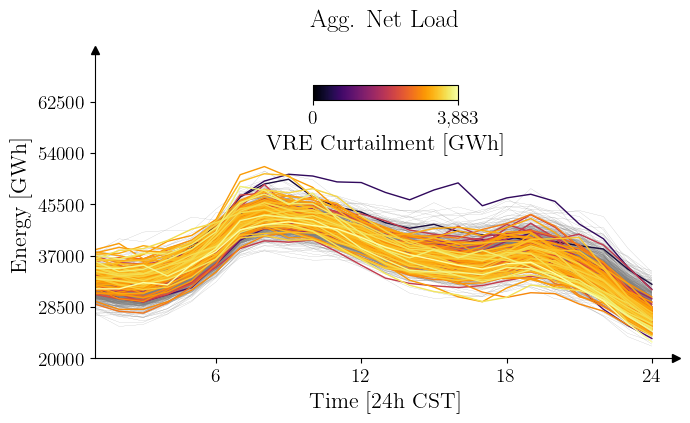

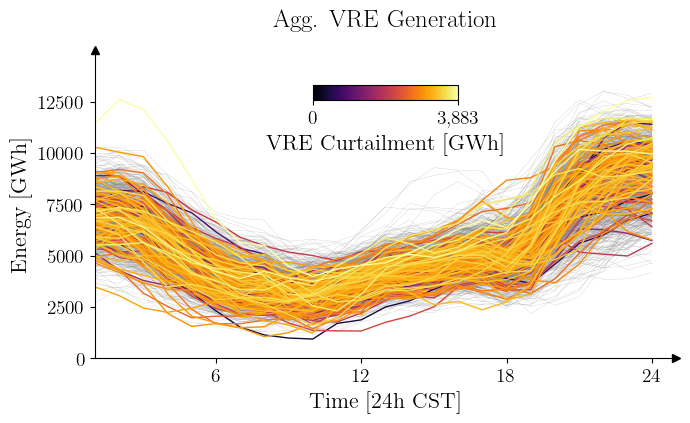

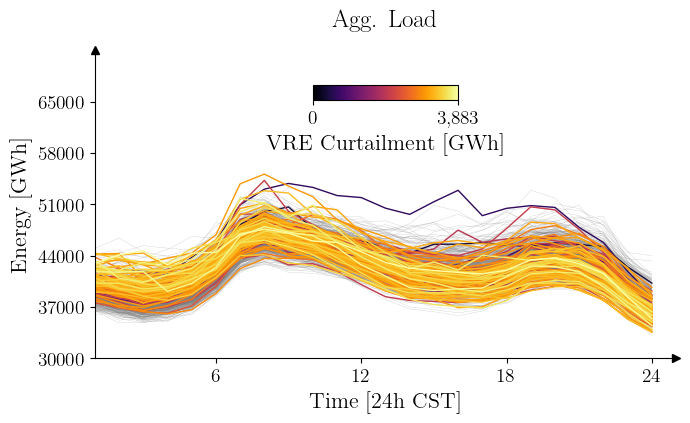

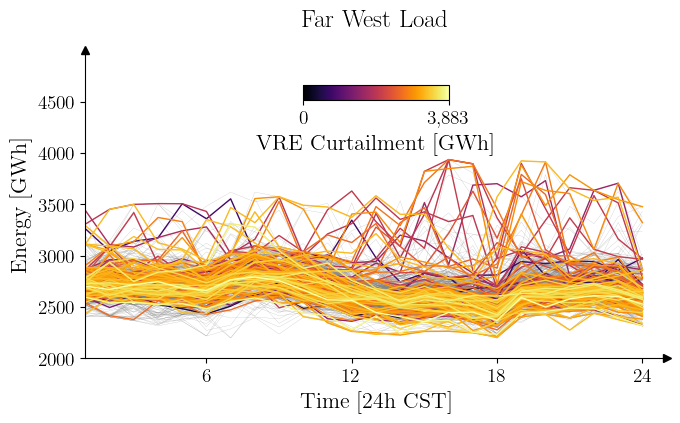

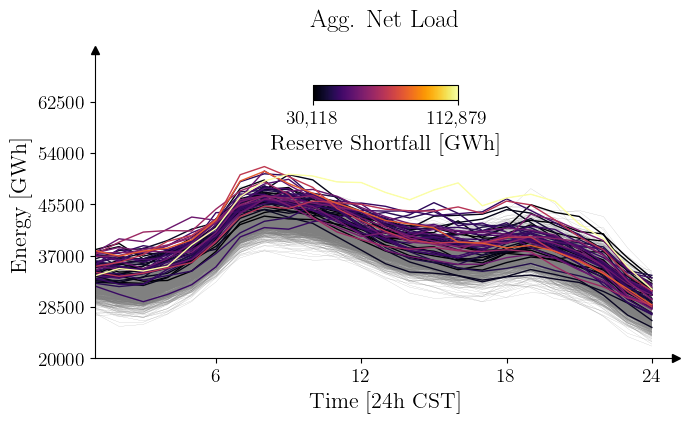

In [7]:
def _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic, i_feature, i_zone, vmin = 15000, vmax = 45000, letter = ''):

    fig = plt.figure(figsize = (7.5, 4))
    ax = fig.add_subplot(111) 
    
    min   = np.log(total_[i_vatic][sort_[i_vatic][int(idx_[i_vatic].sum())]] + 1.)
    max   = np.log(total_[i_vatic][sort_[i_vatic][0]] + 1.)
    norm  = mpl.colors.Normalize(min/max, 1.)
    
    cmap1 = mpl.cm.ScalarMappable(norm = norm, 
                                  cmap = mpl.cm.inferno)
    cmap1.set_array([])

    ax.set_title(r'{} {}'.format(zones_[i_zone], features_[i_feature]), fontsize = 18, y = 1.05)
    ax.plot(X_[i_feature][i_zone, ...], 'gray', linewidth = .1)
    for i in reversed(range(idx_[i_vatic].sum())):
        scale = np.log(total_[i_vatic][sort_[i_vatic][i]] + 1.)/max
        ax.plot(X_[i_feature][i_zone, :, sort_[i_vatic][i]], color = cmap1.to_rgba(scale), linewidth = 1., alpha = 1.)

    ax.set_ylabel('Energy [GWh]', fontsize = 16)
    ax.set_xlabel('Time [24h CST]', fontsize = 16)

    ax.spines[["top", "right"]].set_visible(False)

    ax.set_ylim(vmin, vmax)
    ax.set_xlim(0, 24)
    ax.set_xticks([5, 11, 17, 23], [6, 12, 18, 24], fontsize = 14)
    ax.set_yticks(np.linspace(vmin, vmax, 7, dtype = int)[:-1], np.linspace(vmin, vmax, 7, dtype = int)[:-1], fontsize = 14)

    ax.plot(1, vmin, ">k", transform = ax.get_yaxis_transform(), 
                         clip_on   = False)
    ax.plot(0, 1, "^k", transform = ax.get_xaxis_transform(), 
                         clip_on   = False)

#     cax = fig.add_axes([.4, .75, 0.25, .05])
#     cb = mpl.colorbar.ColorbarBase(cax, cmap        = cmap1, 
#                                         orientation = 'horizontal')

    cbaxes = inset_axes(ax, width     = "25%", 
                            height    = "5%", 
                            loc       = 'upper center',
                            borderpad = 2.5) 

    cbar = fig.colorbar(cmap1, ax  = ax, 
                               cax = cbaxes, orientation = 'horizontal')
    
    cbar.set_ticks([min/max, 1.])
    cbar.set_ticklabels([f"{int(total_[i_vatic][sort_[i_vatic][int(idx_[i_vatic].sum())]]):,.0f}", 
                         f"{int(total_[i_vatic][sort_[i_vatic][0]]):,.0f}"])
    
    cbar.ax.tick_params(labelsize = 14)
    
    units_ = ['[\$]', '[GWh]', '[GWh]', '[GWh]']

    cbar.set_label(r'{} {}'.format(vatic_[i_vatic], units_[i_vatic]), fontsize = 16)
    
    ax.text(-3, vmax, letter, fontsize = 22)

    plt.savefig(path_to_images + r"{}{}{}{}.pdf".format(i_day, i_vatic, i_feature, i_zone), dpi = 300, bbox_inches = 'tight')

    plt.show()
    
print(X_.shape, idx_.shape, total_.shape, sort_.shape)
    
# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 0, i_feature = 4, i_zone = 0, vmin = 20000, vmax = 71000)

# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 1, i_feature = 4, i_zone = 0, vmin = 20000, vmax = 71000)
# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 1, i_feature = 4, i_zone = 5, vmin = 7500, vmax = 30000)

# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 4, i_zone = 0, vmin = 20000, vmax = 71000)
# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 3, i_zone = 0, vmin = 0, vmax = 15000)
# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 0, vmin = 30000, vmax = 72000)
# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 3, vmin = 2000, vmax = 5000)

# _vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 3, i_feature = 4, i_zone = 0, vmin = 20000, vmax = 71000)

In [36]:
# Index day to plot
i_day     = 12
print(dates_[i_day])

L_ = np.concatenate([np.sum(allL_[i_day, ...], axis = 0)[np.newaxis, ...], allL_[i_day, ...]], axis = 0)
S_ = np.concatenate([np.sum(allS_[i_day, ...], axis = 0)[np.newaxis, ...], allS_[i_day, ...]], axis = 0)
W_ = np.concatenate([np.sum(allW_[i_day, ...], axis = 0)[np.newaxis, ...], allW_[i_day, ...]], axis = 0)
G_ = S_ + W_
N_ = L_ - G_
X_ = [L_, S_, W_, G_, N_]
print(L_.shape, S_.shape, W_.shape, G_.shape, N_.shape)

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
Shed_    = np.sum(allV_[i_day, 2, :, :], axis = 0)
idxShed_ = Shed_ > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
Curt_    = np.sum(allV_[i_day, 8, :, :], axis = 0)
idxCurt_ = Curt_ > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

Cost_    = np.sum(allV_[i_day, 1, :, :], axis = 0)
Short_   = np.sum(allV_[i_day, 5, :, :], axis = 0)

print(np.where(allV_[i_day, 2, 1:-1, :] == allV_[i_day, 2, 1:-1, :].max()))
print(np.where(allV_[i_day, 8, 1:-1, :] == allV_[i_day, 8, 1:-1, :].max()))

sortShed_  = np.argsort(Shed_)[::-1]
sortCurt_  = np.argsort(Curt_)[::-1]
sortCost_  = np.argsort(Cost_)[::-1]
sortShort_ = np.argsort(Short_)[::-1]
idxCost_   = idxScen_ < 50
idxShort_  = idxScen_ < 50

sort_  = [sortCost_, sortShed_, sortCurt_, sortShort_]
total_ = [Cost_, Shed_, Curt_, Short_]
idx_   = [idxCost_, idxShed_, idxCurt_, idxShort_]
print(sortCost_.shape, idxCost_.shape, Cost_.shape, sortShed_.shape, idxShed_.shape, Shed_.shape)

2018-06-30
(9, 24, 1000) (9, 24, 1000) (9, 24, 1000) (9, 24, 1000) (9, 24, 1000)
213 336 181
(array([15]), array([994]))
(array([8]), array([382]))
(1000,) (1000,) (1000,) (1000,) (1000,) (1000,)


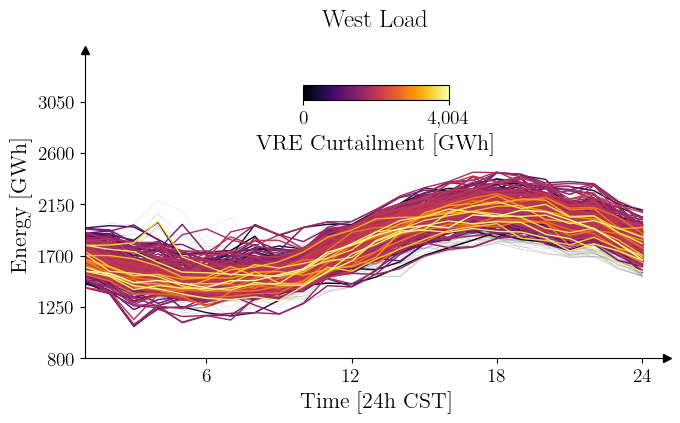

In [51]:
#_vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 5, vmin = 7000, vmax = 40000)
#_vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 7, vmin = 4000, vmax = 19000)
#_vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 8, vmin = 800, vmax = 3500)

In [62]:
# Index day to plot
i_day     = 4
print(dates_[i_day])

L_ = np.concatenate([np.sum(allL_[i_day, ...], axis = 0)[np.newaxis, ...], allL_[i_day, ...]], axis = 0)
S_ = np.concatenate([np.sum(allS_[i_day, ...], axis = 0)[np.newaxis, ...], allS_[i_day, ...]], axis = 0)
W_ = np.concatenate([np.sum(allW_[i_day, ...], axis = 0)[np.newaxis, ...], allW_[i_day, ...]], axis = 0)
G_ = S_ + W_
N_ = L_ - G_
X_ = [L_, S_, W_, G_, N_]
print(L_.shape, S_.shape, W_.shape, G_.shape, N_.shape)

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
Shed_    = np.sum(allV_[i_day, 2, :, :], axis = 0)
idxShed_ = Shed_ > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
Curt_    = np.sum(allV_[i_day, 8, :, :], axis = 0)
idxCurt_ = Curt_ > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

Cost_    = np.sum(allV_[i_day, 1, :, :], axis = 0)
Short_   = np.sum(allV_[i_day, 5, :, :], axis = 0)

print(np.where(allV_[i_day, 2, 1:-1, :] == allV_[i_day, 2, 1:-1, :].max()))
print(np.where(allV_[i_day, 8, 1:-1, :] == allV_[i_day, 8, 1:-1, :].max()))

sortShed_  = np.argsort(Shed_)[::-1]
sortCurt_  = np.argsort(Curt_)[::-1]
sortCost_  = np.argsort(Cost_)[::-1]
sortShort_ = np.argsort(Short_)[::-1]
idxCost_   = idxScen_ < 50
idxShort_  = idxScen_ < 50

sort_  = [sortCost_, sortShed_, sortCurt_, sortShort_]
total_ = [Cost_, Shed_, Curt_, Short_]
idx_   = [idxCost_, idxShed_, idxCurt_, idxShort_]
print(sortCost_.shape, idxCost_.shape, Cost_.shape, sortShed_.shape, idxShed_.shape, Shed_.shape)

NameError: name 'dates_p_' is not defined

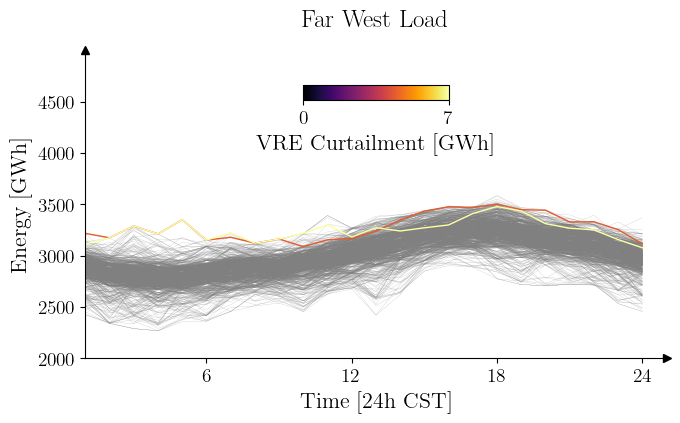

In [61]:
_vatic_ranking_plot(X_, idx_, total_, sort_, i_day, i_vatic = 2, i_feature = 0, i_zone = 3, vmin = 2000, vmax = 5000)

# Vatic Input 

In [8]:
from matplotlib.pyplot import rc
import matplotlib.pyplot as plt

import os, glob, csv

import pandas as pd
import numpy as np
# #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex = True)

path_to_images = r"/Users/Guille/Dropbox/ProcessedDataTexas/images/"
path_to_data   = r"/Users/Guille/Desktop/extreme_scenarios/data/"

# Load all datasets (load, solar, wind) of a given day
def _load_all_datasets(path_to_data):
    # Load csv avoiding errors in the headers
    def __read_csv_file(file_name):
        with open(file_name) as _file:
            rows_ = []
            for row in csv.reader(_file, delimiter = ','):
                row = np.asarray(row[2:])[:, np.newaxis]
                rows_.append(row)
        rows_.pop(0)
        return np.concatenate(rows_, axis = 1).T
    # Load a load, solar or wind file
    def __load_dataset(path_to_data, source):
        y_ac_all_ = []
        y_fc_all_ = []
        Y_sc_all_ = []
        names_    = []
        # Loop over found files in the directory
        for file_ in os.listdir(path_to_data + source):
            names_.append(file_[:file_.find('.csv')].replace('_', ' '))
            # Read .csv file using pandas
            Y_    = pd.read_csv(path_to_data + source + file_)

            # Remove headers and row names and get time series
            y_ac_ = Y_.to_numpy()[0, 2:]
            y_fc_ = Y_.to_numpy()[1, 2:]
            Y_sc_ = Y_.to_numpy()[2:, 2:].T

            # Read .csv file using csv
            Y_    = __read_csv_file(path_to_data + source + file_)
            y_ac_ = Y_[0, :].astype(float)
            y_fc_ = Y_[1, :].astype(float)
            Y_sc_ = Y_[2:, :].astype(float).T

            y_ac_all_.append(y_ac_[:, np.newaxis])
            y_fc_all_.append(y_fc_[:, np.newaxis])
            Y_sc_all_.append(Y_sc_[..., np.newaxis])

        return np.concatenate(y_ac_all_, axis = 1), np.concatenate(y_fc_all_, axis = 1), np.concatenate(Y_sc_all_, axis = 2), np.array(names_)
    
    L_ac_, L_fc_, L_sc_, L_names_ = __load_dataset(path_to_data, source = r'/load/')
    S_ac_, S_fc_, S_sc_, S_names_ = __load_dataset(path_to_data, source = r'/solar/')
    W_ac_, W_fc_, W_sc_, W_names_ = __load_dataset(path_to_data, source = r'/wind/')
    return [L_ac_, L_fc_, L_sc_, L_names_], [S_ac_, S_fc_, S_sc_, S_names_], [W_ac_, W_fc_, W_sc_, W_names_]

date = '20180722'
L_, S_, W_ = _load_all_datasets(path_to_data + r'SimDat_{}/'.format(date))
print(L_[0].shape, L_[1].shape, L_[2].shape, L_[3].shape)
print(S_[0].shape, S_[1].shape, S_[2].shape, S_[3].shape)
print(W_[0].shape, W_[1].shape, W_[2].shape, W_[3].shape)

# Aggregate actual from load, solar and wind
L_ac_total_ = np.sum(L_[0], axis = 1)
S_ac_total_ = np.sum(S_[0], axis = 1)
W_ac_total_ = np.sum(W_[0], axis = 1)
print(L_ac_total_.shape, S_ac_total_.shape, W_ac_total_.shape)

# Aggregate forecast from load, solar and wind
L_fc_total_ = np.sum(L_[1], axis = 1)
S_fc_total_ = np.sum(S_[1], axis = 1)
W_fc_total_ = np.sum(W_[1], axis = 1)
print(L_fc_total_.shape, S_fc_total_.shape, W_fc_total_.shape)

# Aggregate sceneratios from load, solar and wind
L_sc_total_ = np.sum(L_[2], axis = 2)
S_sc_total_ = np.sum(S_[2], axis = 2)
W_sc_total_ = np.sum(W_[2], axis = 2)
print(L_sc_total_.shape, S_sc_total_.shape, W_sc_total_.shape)

(24, 8) (24, 8) (24, 1000, 8) (8,)
(24, 226) (24, 226) (24, 1000, 226) (226,)
(24, 264) (24, 264) (24, 1000, 264) (264,)
(24,) (24,) (24,)
(24,) (24,) (24,)
(24, 1000) (24, 1000) (24, 1000)


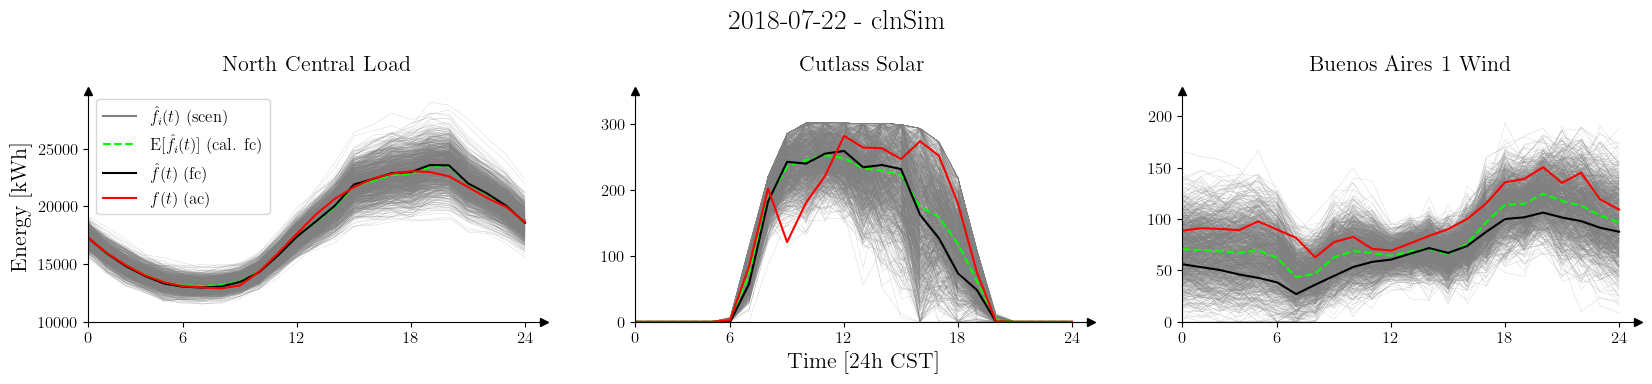

In [9]:
i_asset = 2

fig = plt.figure(figsize = (20, 3))

plt.suptitle('2018-07-22 - clnSim', y = 1.15, fontsize = 20)

ax = fig.add_subplot(131) 
ax.set_title('{} Load'.format(L_[3][i_asset]), fontsize = 16, y = 1.05)
ax.plot(L_[2][..., i_asset], 'gray', linewidth = .1)
ax.plot(L_[2][..., i_asset][..., 0], 'gray', linewidth = 1.5, label = '$\hat{f}_i(t)$ (scen)')

ax.plot(np.mean(L_[2][..., i_asset], axis = 1), c = 'lime', linestyle = '--', linewidth = 1.5, 
        label = 'E$[ \hat{f}_i(t)]$ (cal. fc)')
ax.plot(L_[1][..., i_asset], c = 'k', linewidth = 1.5, label = '$\hat{f}(t)$ (fc)')
ax.plot(L_[0][..., i_asset], c = 'r', linewidth = 1.5, label = '$f(t)$ (ac)')

ax.set_ylabel('Energy [kWh]', fontsize = 16)
#ax.set_xlabel('Time [24h CST]', fontsize = 16)

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left"]].set_position(("data", 0))
# ax.spines[[ "bottom"]].set_position(("data", 0))


ax.plot(0, 1, "^k", transform = ax.get_xaxis_transform(), 
                     clip_on   = False)

ax.plot(1, 10000, ">k", transform = ax.get_yaxis_transform(), 
                     clip_on   = False)

ax.set_ylim(10000, 30000)
ax.set_xlim(0, 24)
ax.set_yticks([10000, 15000, 20000, 25000], [10000, 15000, 20000, 25000], fontsize = 12)
ax.set_xticks([0, 5, 11, 17, 23], [0, 6, 12, 18, 24], fontsize = 12)

ax.legend(prop={'size': 12})

i_asset = 8

ax = fig.add_subplot(132) 

ax.set_title('{}'.format(S_[3][i_asset]), fontsize = 16, y = 1.05)
ax.plot(S_[2][..., i_asset], 'gray', linewidth = .1)
ax.plot(np.mean(S_[2][..., i_asset], axis = 1), c = 'lime', linestyle = '--', linewidth = 1.5, label = 'Ex. Scen.')
ax.plot(S_[1][..., i_asset], 'k', linewidth = 1.5, marker = 'None', label = 'fc')
ax.plot(S_[0][..., i_asset], 'r', linewidth = 1.5, marker = 'None', label = 'ac')

#ax.set_ylabel('Energy [kWh]', fontsize = 16)
ax.set_xlabel('Time [24h CST]', fontsize = 16)

ax.spines[["top", "right"]].set_visible(False)

# ax.spines[["left"]].set_position(("data", -1))
# ax.spines[[ "bottom"]].set_position(("data", -15))

ax.plot(1, 0, ">k", transform = ax.get_yaxis_transform(), 
                     clip_on   = False)
ax.plot(0, 1, "^k", transform = ax.get_xaxis_transform(), 
                     clip_on   = False)

ax.set_ylim(0, 350)
ax.set_xlim(0, 24)
ax.set_yticks([0, 100, 200, 300], [0, 100, 200, 300], fontsize = 12)
ax.set_xticks([0, 5, 11, 17, 23], [0, 6, 12, 18, 24], fontsize = 12)

i_asset = 3

ax = fig.add_subplot(133) 

ax.set_title('{}'.format(W_[3][i_asset]), fontsize = 16, y = 1.05)
ax.plot(W_[2][..., i_asset], 'gray', linewidth = .1)
ax.plot(np.mean(W_[2][..., i_asset], axis = 1), 'lime', linestyle = '--', linewidth = 1.5, label = 'Ex. Scen.')
ax.plot(W_[1][..., i_asset], 'k', linewidth = 1.5, label = 'fc')
ax.plot(W_[0][..., i_asset], 'r', linewidth = 1.5, label = 'ac')

#ax.set_ylabel('Energy [kWh]', fontsize = 16)
#ax.set_xlabel('Time [24h CST]', fontsize = 16)

ax.spines[["top", "right"]].set_visible(False)
# ax.spines[["left"]].set_position(("data", -1))
# ax.spines[[ "bottom"]].set_position(("data", -10))

ax.set_ylim(0, 225)
ax.set_xlim(0, 24)
ax.set_yticks([0, 50, 100, 150, 200], [0, 50, 100, 150, 200], fontsize = 12)
ax.set_xticks([0, 5, 11, 17, 23], [0, 6, 12, 18, 24], fontsize = 12)

ax.plot(1, 0, ">k", transform = ax.get_yaxis_transform(), 
                     clip_on   = False)
ax.plot(0, 1, "^k", transform = ax.get_xaxis_transform(), 
                     clip_on   = False)
plt.savefig(path_to_images + r"{}_scen.pdf".format(date), dpi = 250, bbox_inches = 'tight')
plt.show()

In [10]:
def _plot(summary_, date):
    
    # Reliability Metrics
    LOLP = np.sum(summary_[:, 2, :] > 0.)/(24*summary_.shape[-1])
    LOLH = (365*24)*np.sum(summary_[:, 2, :] > 0.)/(24*summary_.shape[-1])
    EUE  = 100*summary_[:, 2, :].sum()/summary_[:, 9, :].sum()
    print(np.sum(summary_[:, 2, :] > 0., axis = -1))
    print(np.sum(np.sum(summary_[:, 2, :] > 0., axis = 0) > 0.))
    
    plt.figure(figsize = (15, 3))
    plt.suptitle(date + ' LOLP = {} [Prob.]'.format(LOLP) + ' LOLH = {} [hours]'.format(LOLH) + ' EUE = {} [%]'.format(EUE), fontsize = 10)
    plt.subplot(131)
    plt.title('Fx. & Vr. Costs', fontsize = 8)
    plt.plot(summary_[:, 1, :], color = 'gray', lw = .25)
    plt.plot(summary_[:, 0, :], color = 'r', lw = .25)
    #plt.ylim(0, 7000)
    plt.subplot(132)
    plt.title('Load Shedding', fontsize = 8)
    plt.plot(summary_[:, 2, :], color = 'gray', lw = .25)
    #plt.ylim(0, 7000)
    plt.subplot(133)
    plt.title('VRE Curtailment', fontsize = 8)
    plt.plot(summary_[:, 8, :], color = 'gray', lw = .25)
    #plt.ylim(0, 5000)
    plt.savefig(path_to_images + '{}.pdf'.format(date), dpi = 300, bbox_inches = 'tight')
    plt.show()

def _load(path):
    summary_ = []
    for file in glob.glob(path + r'/*'):
        summary_.append(pd.read_pickle(file).to_numpy()[..., np.newaxis])
    return np.concatenate(summary_, axis = 2)


all_mean_load_shed_ = []
all_prob_load_shed_ = []
all_mean_vre_curtail_ = []
all_prob_vre_curtail_ = []
month_ = []
for file_ in glob.glob(path_to_vatic_outputs + '*'):
    print(file_)
    
    summary_ = _load(file_)
    
    _plot(summary_, date = file_[-10:])

    all_mean_load_shed_.append(np.mean(summary_[:, 2, :], axis = -1))
    all_prob_load_shed_.append(np.sum(summary_[:, 2, :] > 0., axis = -1))
    all_mean_vre_curtail_.append(np.mean(summary_[:, 8, :], axis = -1))
    all_prob_vre_curtail_.append(np.sum(summary_[:, 8, :] > 0., axis = -1))
    
    month_.append(int(file_[-5:-3]))
    
    
all_mean_load_shed_ = np.stack(all_mean_load_shed_).T
all_prob_load_shed_ = np.stack(all_prob_load_shed_).T
print(all_mean_load_shed_.shape, all_prob_load_shed_.shape)

all_mean_vre_curtail_ = np.stack(all_mean_vre_curtail_).T
all_prob_vre_curtail_ = np.stack(all_prob_vre_curtail_).T
print(all_mean_vre_curtail_.shape, all_prob_vre_curtail_.shape)

month_ = np.array(month_)
print(month_.shape)

print(month_)

/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/VaticLMPTexas


IsADirectoryError: [Errno 21] Is a directory: '/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/VaticLMPTexas/2018-10-04'

In [ ]:
# Load Shedding Stats graph
def _plot_load_shed_stats(all_mean_load_shed_, all_prob_load_shed_, month_, vmin = .075):
    all_prob_load_shed_p_ = all_prob_load_shed_/vmin
    x_ = np.arange(0, all_prob_load_shed_.shape[0], 1)
    y_ = all_mean_load_shed_ + 1e-25
    print(x_.shape, y_.shape)

    #plt.style.use('default')
    
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(111) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']
    
    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 7.5, 
                                                  linestyle  = '')

    cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap1, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(0, vmin), 
                                   extend      = 'max',
                                   label       = 'No. Scenarios with Load Shedding',
                                   ticks       = [0., 25, 50, 75])
    
    cax = fig.add_axes([0.41, 0.675, 0.2, 0.02])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap2, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(1, 12), 
                                   label       = 'Month',
                                   ticks       = [1, 4, 8, 12])
    
    ax1.set_ylim(-1, 30000)
    ax1.set_xlim(-1, 24)
    #ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2])
    ax1.set_yscale('symlog') 
    ax1.set_yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected Load Shedding [kW]')
    
    plt.show() 
    
    fig = plt.figure(figsize = (15, 4))
    ax1 = fig.add_subplot(121) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    
    ax1.set_ylim(-1, 800)
    ax1.set_xlim(-1, 24)
    ax1.set_xlim(0, all_mean_load_shed_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2]) 
    ax1.set_yticks([100, 200, 300, 400, 500, 600, 700], [100, 200, 300, 400, 500, 600, 700])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected Load Shedding [kW]')
    
    ax2 = fig.add_subplot(122) 

    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax2.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax2.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax2.plot(1, 0, ">k", transform = ax2.get_yaxis_transform(), 
                         clip_on   = False)
    ax2.plot(0, 1, "^k", transform = ax2.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax2.set_prop_cycle('color', list_)

        ax2.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax2.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    ax2.set_ylim(-0.01, 50)
    ax2.set_xlim(-1, 24)
    ax2.set_xlim(0, all_mean_load_shed_.shape[0] - 1)
    ax2.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2])  
    ax2.set_yticks([10, 20, 30, 40], [10, 20, 30, 40])
    ax2.set_xlabel('Time [24 hours]')
    ax2.set_ylabel('Expected Load Shedding [kW]')
    
    plt.show() 
    
    
# VRE curtailment Stats graph
def _plot_vre_curtail_stats(all_mean_vre_curtail_, all_prob_vre_curtail_, month_, vmin = .075):
    
    all_prob_vre_curtail_p_ = all_prob_vre_curtail_/vmin
    x_ = np.arange(0, all_mean_vre_curtail_.shape[0], 1)
    y_ = all_mean_vre_curtail_ + 1e-25

    #plt.style.use('default')
    
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(111) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    cax = fig.add_axes([0.25, 0.8, 0.5, 0.05])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap1, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(0, vmin), 
                                   extend      = 'max',
                                   label       = 'No. Scenarios with VRE Curtailement',
                                   ticks       = [0., 25, 50, 75])

    cax = fig.add_axes([0.39, 0.675, 0.2, 0.02])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap2, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(1, 12), 
                                   label       = 'Month',
                                   ticks       = [1, 4, 8, 12])
    
    ax1.set_ylim(-1, 30000)
    ax1.set_xlim(-1, 24)
    ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    #ax1.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])
    ax1.set_yscale('symlog')
    ax1.set_yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected VRE Curtailment [kW]')
    plt.show()
    
    fig = plt.figure(figsize = (15, 4))
    ax1 = fig.add_subplot(121) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    
    ax1.set_ylim(-1, 800)
    ax1.set_xlim(-1, 24)

    ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])
    

    #ax1.set_yscale('symlog')
    
    ax1.set_yticks([100, 200, 300, 400, 500, 600, 700], [100, 200, 300, 400, 500, 600, 700])

    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected VRE Curtailment [kW]')
    
    ax2 = fig.add_subplot(122) 

    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax2.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax2.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax2.plot(1, 0, ">k", transform = ax2.get_yaxis_transform(), 
                         clip_on   = False)
    ax2.plot(0, 1, "^k", transform = ax2.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax2.set_prop_cycle('color', list_)

        ax2.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax2.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    ax2.set_ylim(-0.01, 50)
    ax2.set_xlim(-1, 24)
    ax2.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax2.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])    
    ax2.set_yticks([10, 20, 30, 40], [10, 20, 30, 40])
    ax2.set_xlabel('Time [24 hours]')
    ax2.set_ylabel('Expected VRE Curtailment [kW]')
    
    plt.show() 
    
    
_plot_load_shed_stats(all_mean_load_shed_, all_prob_load_shed_, month_, vmin = 75)
_plot_vre_curtail_stats(all_mean_vre_curtail_, all_prob_vre_curtail_, month_, vmin = 75)